In [99]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,9)
import os
import copy
from IPython.display import clear_output
import torch
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader
from torch.autograd import Variable
import PIL
import torch.optim as optim

In [100]:
class Dataset:
    """load the image / encoded object position representation pairs for training and testing data"""
    def __init__(self, path, mode = 'train'):
        self.path=path
        self.mode=mode

    def __getitem__(self, index):
        mode = self.mode
        if mode=='train':
            fname = '/train-%04d.jpg'
        elif mode=='test':
            fname = '/test-%04d.jpg'
            
        if mode=='train':
            fname1 = 'train-comp-%04d.npy'
        elif mode=='test':
            fname1 = 'test-comp-%04d.npy'
        img = PIL.Image.open(self.path+fname%index)
        vect = np.load(self.path+fname1%index)
        transform = transforms.Compose([transforms.Resize((227,227)), #224? 
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                       ])
        img = transform(img)
        img.requires_grad=True
        vect = torch.FloatTensor(np.concatenate(vect)) 
        return img, vect 

    def __len__(self):
        return len([f for f in os.listdir(self.path) if f.endswith('.jpg')])

In [106]:
# Initialize dataset iterators and find gpu if available 
train_data = Dataset('./data/training/',mode='train')
test_data = Dataset('./data/testing/',mode='test')
print('data is loaded')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is '+ str(device))

data is loaded
device is cpu


In [147]:
x,y = train_data[0]
x = x.unsqueeze(0)
y = y.unsqueeze(0)

In [159]:
f1 = nn.Conv2d(1,5,5,1)
f2 = nn.MaxPool2d(2,2)
f3 = nn.Conv2d(5,10,3,1)
f4 = nn.Linear(10*109**2, 15000)
f5 = nn.Linear(15000,500)

In [161]:
f3(f2(f1(x))).shape

torch.Size([1, 10, 109, 109])

In [170]:
nn.Conv2d(5,10,3,1)(nn.MaxPool2d(2,2)(nn.Conv2d(1,5,11,4)(x))).shape

torch.Size([1, 10, 25, 25])

In [207]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,11,4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6,12,5,1)
        self.fc1 = nn.Linear(12*11**2, 12*11**2)
        self.fc2 = nn.Linear(12*11**2,500)
        #self.fc3 = nn.Linear(12*11**2/2,500)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12*11**2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x

model = Net()

In [208]:
model.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(),lr=0.000001,momentum=0.9,weight_decay = 0.0005) # fails because bad initialization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
losses = []

In [209]:
k = 128 #size of batch sgd at 0.01 does not train if batch is 50 
N = 500 #number epochs
b = int(len(train_data)/k) #number of batches

train_loader = DataLoader(train_data , batch_size = k, shuffle = True) #batch data loader

for epoch in range(N): # epoch iterator 
    
    running_loss = 0 # mean loss per epoch 
    
    for i, (inputs, targets) in enumerate(train_loader): # batch iterator 
        
        inputs, targets = inputs.to(device), targets.to(device) # batch to gpu
        optimizer.zero_grad() # zero gradients
        outputs = model(inputs) # model prediction
        loss = criterion(outputs,targets)  # loss computation
        loss.backward() #backpropagation
        optimizer.step() #gradient descent 
        running_loss+=loss.cpu().data.item()

    # clear_output(wait=True)
    print('epoch loss: ',round(running_loss/i,2)) # print/store loss
    if epoch%10==0 and epoch!=0:     
        n = epoch
        #torch.save(model,'%03d-epochs.pt'%n)
    losses.append(running_loss/i)
    scheduler.step(running_loss/i)

epoch loss:  213890.72
epoch loss:  133101.66
epoch loss:  112038.64
epoch loss:  93366.46
epoch loss:  55542.04
epoch loss:  28270.73


KeyboardInterrupt: 

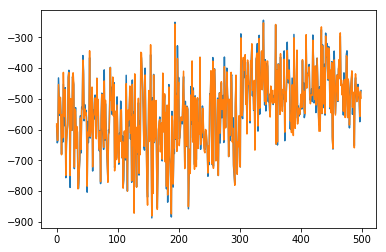

In [55]:
n = 22 # the number of the last batch you wanna look at 
plt.plot(targets.numpy()[n]) # plot the targets 
plt.plot(outputs.detach().numpy()[n]) # plot the model outputs 

In [39]:
import compression as comp

In [41]:
S = np.load('./data/sensing_matrix.npy')

In [43]:
x = comp.decode(t[0],S)

In [85]:
conv_layers = model.conv1.weight.detach().numpy().squeeze()

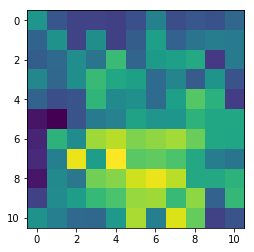

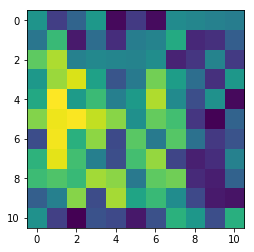

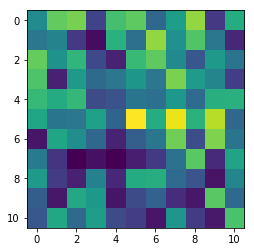

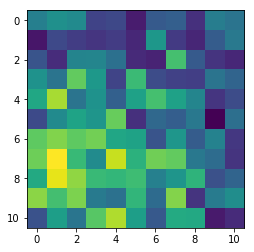

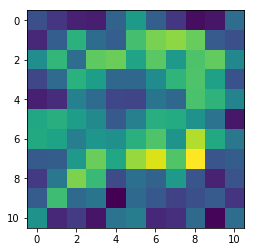

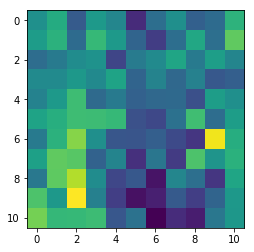

In [86]:
for c in conv_layers:
    plt.imshow(c)
    plt.show()